In [ ]:
# Install keras_tuner for hyper parameter tuning
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import SVG

from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


from IPython.display import Image
import glob
import cv2
import random


from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
import tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband, Objective

input_shape = (128, 128, 3)  # Example input shape for an RGB image
inputs = Input(shape=input_shape)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
from google.colab import drive
drive.mount('/train_val/')

Mounted at /content/drive/
Mounted at /train_val/


In [ ]:
# read the dataframe
dataframes_path = '/train_val/MyDrive/Images/train_val_dataframes'

df = pd.read_csv(dataframes_path + '/combined.csv')

## **Hyper-parameter Tuning Steps**

1. Define a model-building function that takes hyperparameters as an argument.
2. Set up the tuner using Hyperband, RandomSearch, or BayesianOptimization.
3. Run the tuner to find the best hyperparameters.

### **Logic behind choosing Hyper-parameter ranges**

### Convolutional Filters:

The range for the number of filters in each convolutional layer (conv1_filters, conv2_filters, conv3_filters) seems reasonable. we have provided a minimum of 32 filters and gradually increased it up to 128, 256, and 512, respectively. These values cover a wide range of potential filter sizes, allowing the model to capture different levels of abstraction in the data.

### Dense Units:

The range for the number of units in the dense layer (dense_units) has been chosen between 64 and 256. Starting from 64 and increasing up to 256 allows the model to explore different levels of complexity in the fully connected layers, potentially capturing more intricate patterns in the data.


### Dropout Rate:

Dropout helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. By exploring dropout rates from 0.3 to 0.7, we're allowing the model to find an optimal balance between regularization and retaining useful information.

### Learning Rate:

The range for the learning rate (learning_rate) is set using a logarithmic scale, which is common practice in hyperparameter tuning. Learning rates between 1e-4 and 1e-2 cover a wide range of values commonly used in training neural networks. The logarithmic scale helps in exploring both small and large learning rates efficiently.

In [ ]:
def build_model(hp):
    inputs = Input(shape=(128, 128, 3))

    # Shared convolutional base with hyperparameterized filters
    x = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Dense layer with hyperparameterized units and dropout rate
    x = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)

    # Classification and regression outputs
    classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
    regression_output = Dense(1, name='regression_output')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=[classification_output, regression_output])

    # Compile the model with hyperparameterized learning rate
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mse'},
        metrics={'classification_output': 'accuracy', 'regression_output': 'mse'}
    )

    return model

In [ ]:

# Define the hyperparameter tuning process using Hyperband algorithm

tuner = Hyperband(
    build_model,
    objective=Objective("val_classification_output_accuracy", direction="max"),
    max_epochs=40,
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

In [ ]:
# Define image dimensions and batch size

image_rows = 128
image_cols = 128
batch_size = 4096

# Split data for gender classification

X   = df.drop(['Age', 'Gender'], axis = 1)
y = df['Gender']
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# Split data for age regression
y = df['Age']
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# Define image shape

image_shape = (image_rows,image_cols,3)

# Prepare data for training

train_data = np.array(X_train, dtype = 'float32')
test_data = np.array(X_test, dtype='float32')

train_data = train_data.reshape(train_data.shape[0],*image_shape)
test_data = test_data.reshape(test_data.shape[0],*image_shape)

# Normalize pixel values

x_train = train_data/255
x_test= test_data/255

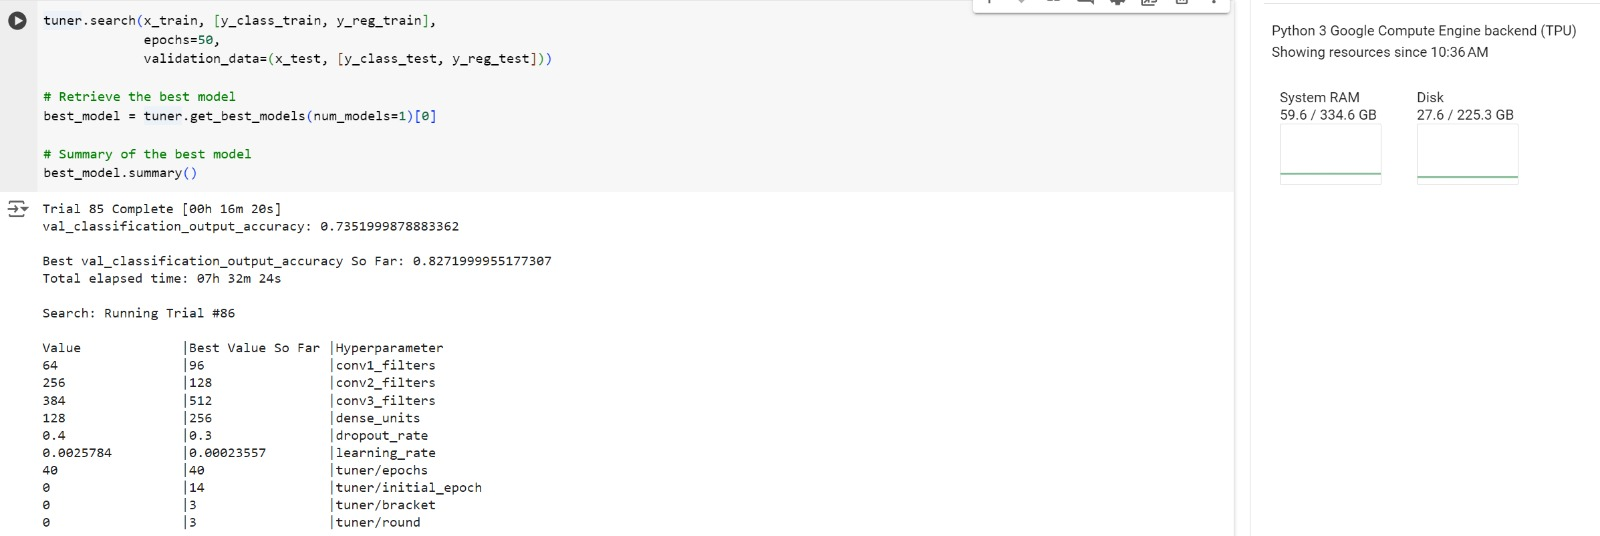

In [ ]:
# Search for the best hyperparameters

tuner.search(x_train, [y_class_train, y_reg_train],
             epochs=50,
             validation_data=(x_test, [y_class_test, y_reg_test]))

# Retrieve the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]

# Print summary of the best model
best_model.summary()

Trial 90 Complete [00h 31m 44s]
val_classification_output_accuracy: 0.823199987411499

Best val_classification_output_accuracy So Far: 0.8271999955177307
Total elapsed time: 10h 14m 53s
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 96)         2688      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 96)           0         ['conv2d[0][0]']              
 D)                                                                                               
       